<a href="https://colab.research.google.com/github/thaCripple/SkinLesion_Classifier_v1/blob/Client-updates/SkinLesions_Classifier_Client.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backend

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import nn
import torchvision
import json
from PIL import Image

In [2]:
import gdown

## Constants

Link to the Google Drive Folder with the model and other data

In [3]:
DATA_URL = "https://drive.google.com/drive/folders/18vhOdDM-rU21D8rztAiEkZ4013MORfIT?usp=sharing"

Class labels

In [4]:
LABELS = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [5]:
CWD = Path.cwd()

In [6]:
device = "cpu"

## Get Required Resources

Download the data folder from google drive

In [7]:
gdown.download_folder(url=DATA_URL, output=str(CWD), quiet=True, use_cookies=False)

['/content/lesions_database.json', '/content/skin_lesion_classifier_model.pth']

Load the model

In [8]:
model_path = CWD / "skin_lesion_classifier_model.pth"

In [9]:
classifier = torch.compile(torch.load(f=model_path, weights_only=False, map_location=torch.device(device)))

Load image transforms

In [10]:
img_transforms = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

Load the Lesions Database

In [11]:
lesions_db_path = CWD / "lesions_database.json"

In [12]:
with open(file=lesions_db_path, mode="r") as file:
  lesions_db = json.load(file)

## Classification Workflow

### Parse and process the Images

In [67]:
def get_images()->list:
  """
  Parses the session storage for .jpg and .png files and converts them to PIL Images

  Returns:
  A list of PIL.Image files

  Raises:
  Exception when no images were found
  """
  img_paths = list(CWD.glob("*.jpg")) + list(CWD.glob("*.png"))
  if len(img_paths) < 1:
    raise Exception("No suitable images found")

  imgs = []
  for img_path in img_paths:
    # In case image is .png (RGBA) convert to RGB
    imgs.append(Image.open(fp=img_path).convert(mode="RGB"))

  return imgs

In [14]:
def transform_image(img:Image)->torch.Tensor:
  """
  Performs transformations required for inference and adds a fake batch dimension of 1 to the output tensor

  Parameters:
    img: A single PIL.Image image

  Returns:
  A Tensor with the transformed image suitable for the model
  """
  return torch.unsqueeze(input=img_transforms(img), dim=0).to(device=device)

### Classify the Images

In [15]:
def classify_img(transformed_img:torch.Tensor, model:nn.Module=classifier)->torch.Tensor:
  """
  Performes inference on the passed image Tensor

  Parameters:
    transformed_img: Image tensor

    model: Pytorch model used for classification

  Returns:
  Tensor with prediction probabilites
  """
  classifier.eval()
  with torch.inference_mode():
    logits = classifier(transformed_img)
    probabilities = nn.functional.softmax(input=logits, dim=1)
  return probabilities

### Perform and present prediction - Main Function

In [52]:
def diagnose_lesions()->None:
  """
  The main function of the application.
  Encapsulates all the previously defined functions.
  1. Opens and transforms user uploaded images
  2. Performs classification and extract classification statistics
  3. Presents the classification to the user
  """

  # Get a list of original images uploaded by the user
  imgs_original = get_images()
  img_count = len(imgs_original)

  # Create a figure for prediction display
  fig, ax = plt.subplots(nrows=img_count, ncols=2, figsize=(8, 5*img_count))

  # If there's only one image add a fake dimension to the ax array to avoid indexing errors
  if img_count == 1:
    ax = ax.reshape((1,2))

  for i in range(img_count):
    original_img = imgs_original[i]

    # Transform the image for the model
    img_transformed = transform_image(img=original_img)

    # Classify the image
    probabilities = classify_img(transformed_img=img_transformed)
    label = LABELS[torch.argmax(input=probabilities)] # Symbolic label eg.: 'bcc'
    confidence = round(probabilities.max().item()*100, 1) # Confidence of the classification
    full_name = lesions_db.get(label)["name"] # Full lesion's name
    description = lesions_db.get(label)["info"] # Lesion's description


    # Get the 2nd most probable classification
    second_classification = torch.sort(probabilities, descending=True)
    second_confidence = round(second_classification.values[0,1].item()*100, 1)
    second_label = LABELS[second_classification.indices[0,1]]
    second_full_name = lesions_db.get(second_label)["name"]
    second_description = lesions_db.get(second_label)["info"]


    # Display the image
    ax[i,0].imshow(original_img)
    ax[i,0].axis(False)

    # Display primary classification information
    confidence_text = f"The Model is {confidence}% certain that the lesion is:"
    ax[i,1].text(x=-.15, y=.9, s=confidence_text, fontsize=10, fontweight="normal", verticalalignment='top') # Confidence
    ax[i,1].text(x=-.15, y=.82, s=full_name, fontsize=10, fontweight="bold", verticalalignment='top') # Classification
    ax[i,1].text(x=-.15, y=.75, s=description, fontsize=10, fontweight="normal", verticalalignment='top') # Description

    # Display secondary classification information
    second_confidence_text = f"The next most probable classification with {second_confidence}% confidence would be:"
    ax[i,1].text(x=-.15, y=.35, s=second_confidence_text, fontsize=9, fontweight="normal", verticalalignment='top') # 2nd Confidence
    ax[i,1].text(x=-.15, y=.30, s=second_full_name, fontsize=9, fontweight="bold", verticalalignment='top') # 2nd Classification
    ax[i,1].text(x=-.15, y=.25, s=second_description, fontsize=9, fontweight="normal", verticalalignment='top') # 2nd Description
    ax[i,1].axis(False)

# Frontend

Drag your images to the **Files** panel on the left and run the cell below

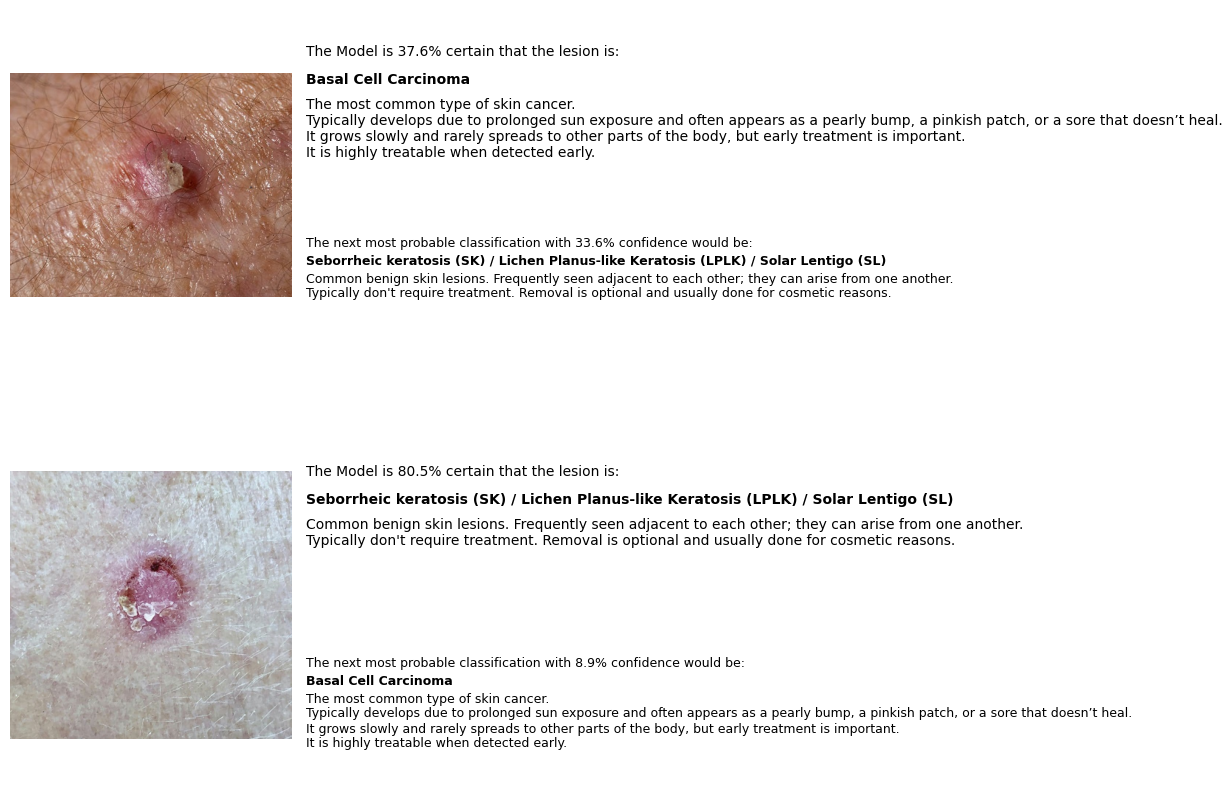

In [66]:
diagnose_lesions()